# TMDB EDA
Author: Michael McCann <br>
Last Updetd: 10 May 2022


## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

## Load and Merge Dataframes
Load the results from our API call (years 2000 - 2021) and concatenate them into one DataFrame.

In [2]:
years = list(range(2000,2022))
tmdb_merged = pd.DataFrame({})

for year in years:
    filepath = f"data/final_tmdb_data_{year}.csv.gz"
    temp = pd.read_csv(filepath)
    tmdb_merged = pd.concat([tmdb_merged, temp], ignore_index = True)
    
    print(f'Year {year} added {temp.shape[0]} new rows to our dataframe. New Total: {tmdb_merged.shape[0]}')
    print('-----')

Year 2000 added 1197 new rows to our dataframe. New Total: 1197
-----
Year 2001 added 1277 new rows to our dataframe. New Total: 2474
-----
Year 2002 added 1218 new rows to our dataframe. New Total: 3692
-----
Year 2003 added 1266 new rows to our dataframe. New Total: 4958
-----
Year 2004 added 1412 new rows to our dataframe. New Total: 6370
-----
Year 2005 added 1602 new rows to our dataframe. New Total: 7972
-----
Year 2006 added 1795 new rows to our dataframe. New Total: 9767
-----
Year 2007 added 1842 new rows to our dataframe. New Total: 11609
-----
Year 2008 added 2073 new rows to our dataframe. New Total: 13682
-----
Year 2009 added 2352 new rows to our dataframe. New Total: 16034
-----
Year 2010 added 2576 new rows to our dataframe. New Total: 18610
-----
Year 2011 added 2897 new rows to our dataframe. New Total: 21507
-----
Year 2012 added 3191 new rows to our dataframe. New Total: 24698
-----
Year 2013 added 3430 new rows to our dataframe. New Total: 28128
-----
Year 2014 add

# Cleaning

In [3]:
display(tmdb_merged.head())
print('\n')
tmdb_merged.info()

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0113026,0.0,/vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",NaN,62127.0,en,The Fantasticks,...,0.0,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Try to remember the first time magic happened,The Fantasticks,0.0,5.4,21.0,NaN
2,tt0113092,0.0,NaN,NaN,0.0,"[{'id': 878, 'name': 'Science Fiction'}]",NaN,110977.0,en,For the Cause,...,0.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The ultimate showdown on a forbidden planet.,For the Cause,0.0,4.4,7.0,NaN
3,tt0116391,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",NaN,442869.0,hi,Gang,...,0.0,152.0,"[{'english_name': 'Hindi', 'iso_639_1': 'hi', ...",Released,NaN,Gang,0.0,0.0,0.0,NaN
4,tt0118694,0.0,/n4GJFGzsc7NinI1VeGDXIcQjtU2.jpg,NaN,150000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",http://www.wkw-inthemoodforlove.com/,843.0,cn,花樣年華,...,12854953.0,99.0,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,"Feel the heat, keep the feeling burning, let t...",In the Mood for Love,0.0,8.1,1860.0,PG




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60102 entries, 0 to 60101
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_id                60102 non-null  object 
 1   adult                  60080 non-null  float64
 2   backdrop_path          36964 non-null  object 
 3   belongs_to_collection  3738 non-null   object 
 4   budget                 60080 non-null  float64
 5   genres                 60080 non-null  object 
 6   homepage               14761 non-null  object 
 7   id                     60080 non-null  float64
 8   original_language      60080 non-null  object 
 9   original_title         60080 non-null  object 
 10  overview               58709 non-null  object 
 11  popularity             60080 non-null  float64
 12  poster_path            54326 non-null  object 
 13  production_companies   60080 non-null  object 
 14  production_countries   60080 non-null  object 
 15  

In [4]:
# Each DF loaded in a first column with 0 as the ID... lets get rid of those.
tmdb_merged = tmdb_merged[tmdb_merged['imdb_id'] != '0']

We retrieved the TMDB data in order to augment/add to the data contained within the IMDB database. The information of interest in the TMDB data is certification, budget, and revenue. For ease of use we will eliminate the unnecessary columns from this DataFrame. 

In [5]:
# Eliminate unnecessary columns for eventual DB creation.
tmdb_merged = tmdb_merged[['imdb_id', 'revenue', 'budget', 'certification']]

In [6]:
budget = tmdb_merged['budget'] > 0
revenue = tmdb_merged['revenue'] > 0
either = tmdb_merged[budget | revenue]

print(f'{budget.sum()} rows have budget information.')
print(f'{revenue.sum()} rows have revenue information.')
print(f'{either["imdb_id"].count()} rows have either budget OR revenue information.')

11048 rows have budget information.
7433 rows have revenue information.
13392 rows have either budget OR revenue information.


In [7]:
tmdb_merged = tmdb_merged[budget | revenue]

In [8]:
tmdb_merged['certification'].unique()

array([nan, 'PG', 'R', 'G', 'PG-13', 'NR', 'NC-17', 'R ', 'PG-13 ',
       'Unrated'], dtype=object)

In [9]:
tmdb_merged['certification'] = tmdb_merged['certification'].str.strip()
tmdb_merged['certification'] = tmdb_merged['certification'].str.replace('Unrated', 'NR')

In [10]:
# Save out DF for use in other steps
tmdb_merged.to_csv(f"data/tmdb_merged.csv.gz", compression="gzip", index=False)

# EDA

In [11]:
tmdb_viz = tmdb_merged.copy()

In [12]:
nr = tmdb_viz['certification'] == 'NR'
unrated = tmdb_viz['certification'] == 'Unrated'
nc17 = tmdb_viz['certification'] == 'NC-17'

tmdb_viz = tmdb_viz[~(nr | unrated | nc17)]
tmdb_viz.dropna(subset= ['certification'], inplace = True)

### Viz: Distriubution by Rating

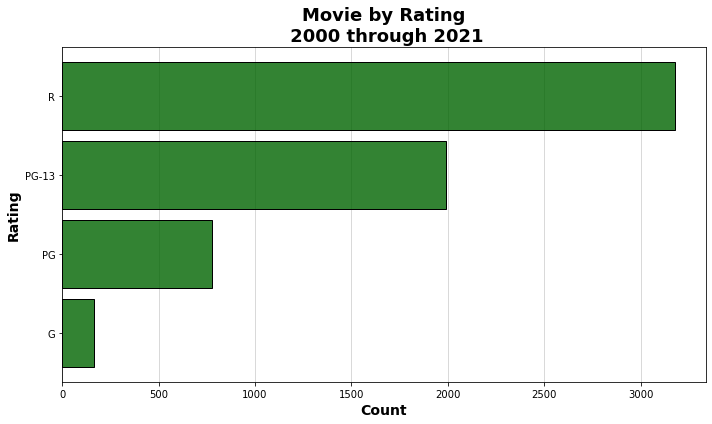

In [13]:
## Set certification to a categorical ordering
tmdb_viz['certification'] = pd.Categorical(tmdb_viz['certification'],
                                           ['R','PG-13','PG','G'])
## Visualize Distribution by Rating
fig, ax = plt.subplots(figsize = (10,6))
sns.histplot(y = tmdb_viz['certification'], 
             color = "#006400", alpha = .8, shrink = .85)
plt.title('Movie by Rating\n 2000 through 2021', 
             fontsize = 18, weight = 'bold')
plt.xlabel('Count', fontsize=14, weight = 'semibold')
plt.ylabel('Rating',  fontsize=14, weight = 'semibold')
plt.grid(axis = 'x', alpha = .6)
ax.set_axisbelow(True)
fig.tight_layout()

### Viz: Mean Budget and Revenue by Rating

In [14]:
tmdb_viz.groupby('certification')['budget'].mean().sort_values(ascending = False)

certification
PG       4.210038e+07
PG-13    4.039237e+07
G        3.108911e+07
R        1.483547e+07
Name: budget, dtype: float64

In [15]:
tmdb_viz.groupby('certification')['revenue'].mean().sort_values(ascending = False)

certification
PG       1.267050e+08
PG-13    1.182030e+08
G        9.362867e+07
R        3.127063e+07
Name: revenue, dtype: float64

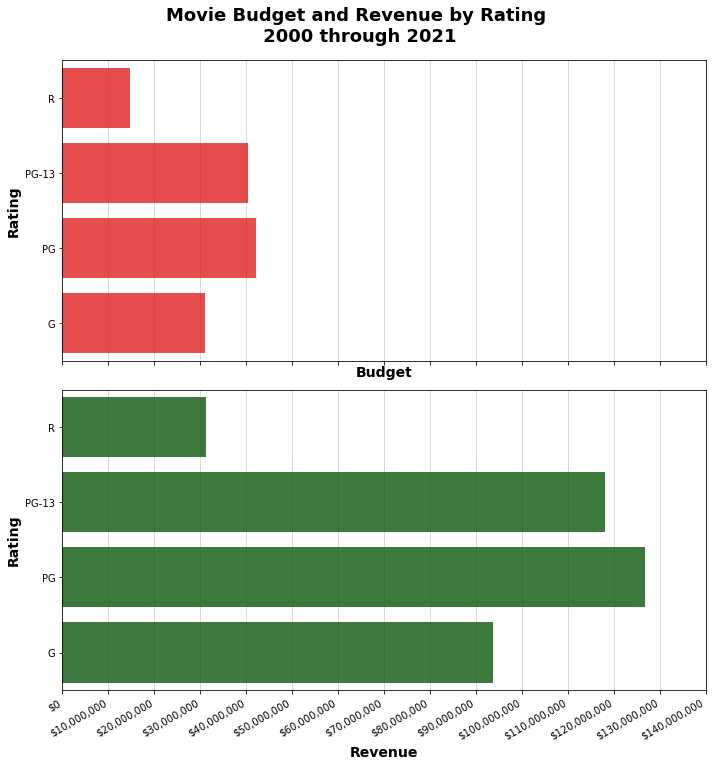

In [16]:
from matplotlib.ticker import StrMethodFormatter

fig, axes = plt.subplots(figsize=(10,10), nrows = 2, sharex = True)
plt.suptitle('Movie Budget and Revenue by Rating\n 2000 through 2021', 
             fontsize = 18, weight = 'bold', y = 1.06)
sns.barplot(data = tmdb_viz, x = 'budget', y = 'certification', 
            ci = None, color = "red", alpha = .8, ax = axes[0])
axes[0].set_xlabel('Budget', fontsize=14, weight = 'semibold')
axes[0].set_ylabel('Rating',  fontsize=14, weight = 'semibold')
sns.barplot(data = tmdb_viz, x = 'revenue', y = 'certification', 
            ci = None, color = "#006400", alpha = .8, ax = axes[1])
axes[1].set_xlabel('Revenue', fontsize=14, weight = 'semibold')
axes[1].set_ylabel('Rating',  fontsize=14, weight = 'semibold')
[ax.grid(axis = 'x', alpha = .6) for ax in axes]
[ax.set_axisbelow(True) for ax in axes]
axes[1].xaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
plt.xlim(0,140000000)
plt.xticks(range(0, 141000000, 10000000),rotation = 30, ha = 'right')
fig.tight_layout()

### Viz: Relationship between Budget and Revenue

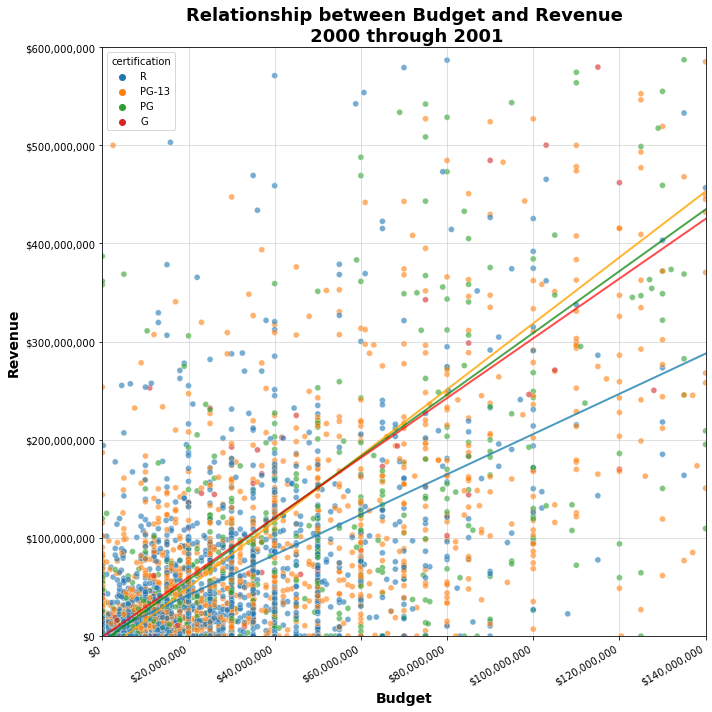

In [17]:
fig, ax = plt.subplots(figsize = (10,10))
sns.scatterplot(data = tmdb_viz, x = 'budget', y = 'revenue', hue = "certification", alpha = .6);
sns.regplot(data=tmdb_viz[tmdb_viz['certification'] == 'R'], x = 'budget', y = 'revenue', 
            scatter_kws={'s':0}, ci=None,
            line_kws={'color': '#1e81b0', 'lw' : 2, 'alpha' : .8})
sns.regplot(data=tmdb_viz[tmdb_viz['certification'] == 'PG-13'], x = 'budget', y = 'revenue', 
            scatter_kws={'s':0}, ci=None,
            line_kws={'color': "orange", 'lw' : 2, 'alpha' : .8})
sns.regplot(data=tmdb_viz[tmdb_viz['certification'] == 'PG'], x = 'budget', y = 'revenue', 
            scatter_kws={'s':0}, ci=None,
            line_kws={'color': "green", 'lw' : 2, 'alpha' : .7})
sns.regplot(data=tmdb_viz[tmdb_viz['certification'] == 'G'], x = 'budget', y = 'revenue', 
            scatter_kws={'s':0}, ci=None,
            line_kws={'color': "red", 'lw' : 2, 'alpha' : .7})
# sns.regplot(data=tmdb_viz[tmdb_viz['certification'] == 'NR'], x = 'budget', y = 'revenue', 
#             scatter_kws={'s':0}, ci=None,
#             line_kws={'color': "purple", 'lw' : 2, 'alpha' : .7})
# sns.regplot(data=tmdb_viz[tmdb_viz['certification'] == 'NC-17'], x = 'budget', y = 'revenue', 
#             scatter_kws={'s':0}, ci=None,
#             line_kws={'color': "brown", 'lw' : 2, 'alpha' : .7})
plt.title('Relationship between Budget and Revenue\n 2000 through 2001', 
             fontsize = 18, weight = 'bold')
plt.xlabel('Budget', fontsize=14, weight = 'semibold')
plt.ylabel('Revenue',  fontsize=14, weight = 'semibold')
ax.xaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
plt.xlim(0,140000000)
plt.ylim(0,600000000)
plt.grid(alpha = .5)
plt.xticks(rotation = 30, ha = 'right')
fig.tight_layout()